In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from collections import Counter
import nltk as nk
from scipy.stats import shapiro, normaltest
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import math
import re

In [2]:
wine_data = pd.read_csv('/Users/ajz/Desktop/DS3001/Project/winemag-data-130k-v2.csv', index_col=0)
wine_data.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
wine_data = wine_data.drop(['taster_twitter_handle','taster_name','province','region_1','region_2'
                                   ,'winery','designation'] ,axis=1)
wine_data.head(5)

,country,description,points,price,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir


In [4]:
wine_data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [5]:
# Check for Duplicated Wines
wine_data.drop_duplicates(inplace=True)
print('Unique Entries: ', len(wine_data))

Unique Entries:  119988


Text(0, 0.5, 'Prices')

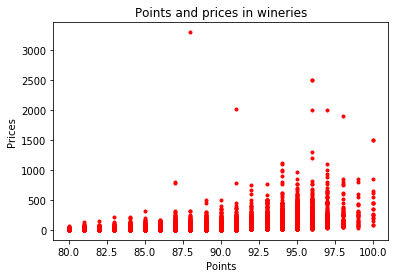

In [6]:
# Plot points vs price data
points = wine_data["points"]
prices = wine_data["price"]
plt.plot(points, prices, "r.")
plt.title("Points and prices in wineries")
plt.xlabel("Points")
plt.ylabel("Prices")

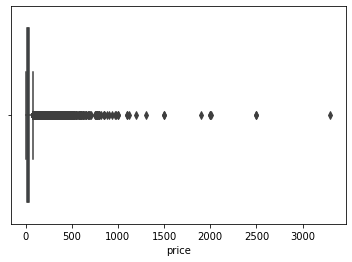

In [7]:
# Box plot to check for outliers 
sns.boxplot(wine_data['price'])

In [8]:
# Find values that are not equal to nan
not_nan =[]
not_nanL = []
for i in range(len(wine_data)):
    if not math.isnan(wine_data.iloc[i,wine_data.columns.get_loc('price')]):
        not_nanL.append(i)
        not_nan.append(wine_data.iloc[i,wine_data.columns.get_loc('price')])

# Test to check if data is Gaussian
    
# normality test
stat, p = normaltest(not_nan)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=235549.471, p=0.000
Sample does not look Gaussian (reject H0)


In [9]:
# Box Plot
Q1 = np.quantile(not_nan, 0.25)
Q3 = np.quantile(not_nan, 0.75)
Q2 = np.quantile(not_nan, 0.50)
IQR = Q3-Q1
print('Q1: ', Q1, 'Q2: ', Q2, 'Q3: ', Q3, 'IQR: ', IQR)
outliers = []
for i in range(len(not_nan)):
    if (not_nan[i] < (Q1 - 1.5 * IQR)) | (not_nan[i] > (Q3 + 1.5 * IQR)):
        outliers.append(not_nanL[i])

Q1:  17.0 Q2:  25.0 Q3:  42.0 IQR:  25.0


In [10]:
# Create list containing no outliers
no_outliers_index = [t for t in not_nanL
                   if t not in outliers]
no_outliers_data = []
for num in no_outliers_index:
    no_outliers_data.append(wine_data.iloc[num, wine_data.columns.get_loc('price')])

Text(0.5, 0, 'Price')

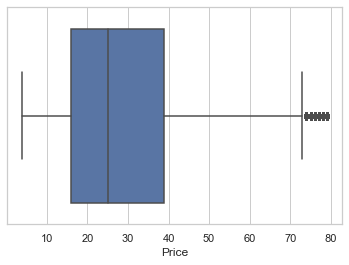

In [11]:
# Price Box Plot with no outliers
sns.set(style="whitegrid")
sns.boxplot(no_outliers_data)
plt.xlabel('Price')

In [12]:
# Remove outliers
wine_data.drop(wine_data.index[outliers], inplace=True)

In [13]:
############ Count for NaN Values

count_country = 0
count_variety = 0
count_price = 0
total=0
count_title = 0
count_description = 0
count_points = 0

index_list_nan = []

# Country NaN
for i in range(len(wine_data)):
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('country')]) == True:
        count_country+=1
        index_list_nan.append(i)

# Variety NaN
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('variety')]) == True:
        count_variety += 1
        index_list_nan.append(i)

# Description NaN
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('description')]) == True:
        count_description += 1
        
# Title NaN    
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('title')]) == True:
        count_title += 1

# Price NaN 
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('price')]) != True:
        count_price+=1
        total+= wine_data.iloc[i, wine_data.columns.get_loc('price')]
        
# Points NaN      
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('points')]) == True:
        count_points += 1
    
     
print(count_country, ' ', count_variety, ' ', count_price, ' ', count_description, ' ', count_title, ' ', 
      count_points)

59   1   104724   0   0   0


In [14]:
# Drop NaN Rows by Index for Categorical Data
wine_data.drop(wine_data.index[index_list_nan], inplace=True)

In [15]:
# Replace NaN values in numerical data with average
for i in range(len(wine_data)):
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('price')]) == True:
          wine_data.iloc[i, wine_data.columns.get_loc('price')] = total/count_price

In [16]:
# Extract Year Out of Title
# Read title and find vintage
yearSearch = []    
for value in wine_data['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(regexresult.group())
    else: yearSearch.append(None)

wine_data['year'] = yearSearch

#Tell me which ones don't have a year listed
print("We extracted %d years from the wine titles and %d did not have a year." 
                                      %(len(wine_data[wine_data['year'].notna()]),
                                            len(wine_data[wine_data['year'].isna()].index)))
wine_data['year'].describe()

We extracted 108958 years from the wine titles and 4101 did not have a year.


count     108958
unique        40
top         2013
freq       13507
Name: year, dtype: object

In [17]:
# If we're missing year values, remove the row
nan_yearL = []
for i in range(len(wine_data)):
    if pd.isna(wine_data.iloc[i, wine_data.columns.get_loc('year')]) == True:
        nan_yearL.append(i)
wine_data.drop(wine_data.index[nan_yearL], inplace=True)
wine_data.drop(['title'], axis=1, inplace=True)

In [18]:
wine_data['wine_keywords'] = wine_data['description'].apply(lambda x: x.lower().split())

In [19]:
wine_data.drop(['description'], axis=1 , inplace=True)
wine_data.head(5)

,country,points,price,variety,year,wine_keywords
0,Italy,87,29.123639,White Blend,2013,"[aromas, include, tropical, fruit,, broom,, br..."
1,Portugal,87,15.000000,Portuguese Red,2011,"[this, is, ripe, and, fruity,, a, wine, that, ..."
2,US,87,14.000000,Pinot Gris,2013,"[tart, and, snappy,, the, flavors, of, lime, f..."
3,US,87,13.000000,Riesling,2013,"[pineapple, rind,, lemon, pith, and, orange, b..."
4,US,87,65.000000,Pinot Noir,2012,"[much, like, the, regular, bottling, from, 201..."


In [20]:
wine_terms = pd.read_csv('/Users/ajz/Desktop/DS3001/Project/wine-terms.csv')
wine_aromas = pd.read_csv('/Users/ajz/Desktop/DS3001/Project/wine-aromas.csv')


terms_list = []
for term in wine_terms['Terms']:
    terms_list.append(term.lower())
    
aromas_list = []
for aroma in wine_aromas['Aromas']:
    aromas_list.append(aroma.lower())


# Add a score inplace for the description by adding the number of times a word of a the description appear
# in the top 50 words list

for i in range(len(wine_data)):
    count = 0
    j = wine_data.iloc[i, wine_data.columns.get_loc('wine_keywords')]  
    
    for k in range(len(j)):
        j[k] = j[k].strip(',.')
        
    for k in range(len(j)):
        if j[k] in terms_list:
            count += 1
        if j[k] in aromas_list:
            count += 1
       
    wine_data.iloc[i, wine_data.columns.get_loc('wine_keywords')]= count

In [21]:
wine_data.head(30)

,country,points,price,variety,year,wine_keywords
0,Italy,87,29.123639,White Blend,2013,3
1,Portugal,87,15.000000,Portuguese Red,2011,2
2,US,87,14.000000,Pinot Gris,2013,5
3,US,87,13.000000,Riesling,2013,6
4,US,87,65.000000,Pinot Noir,2012,4
5,Spain,87,15.000000,Tempranillo-Merlot,2011,10
6,Italy,87,16.000000,Frappato,2013,4
7,France,87,24.000000,Gewürztraminer,2012,3
8,Germany,87,12.000000,Gewürztraminer,2013,3
9,France,87,27.000000,Pinot Gris,2012,7


Text(0, 0.5, 'Prices')

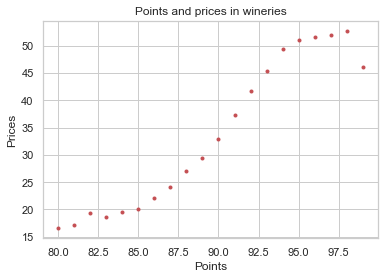

In [22]:
# Plot points vs price data
# Grouping by points
pointsGroup = wine_data.groupby('points').mean()
#prices = wine_data["price"]
plt.plot(pointsGroup ,"r.")
plt.title("Points and prices in wineries")
plt.xlabel("Points")
plt.ylabel("Prices")

Text(0, 0.5, 'Points')

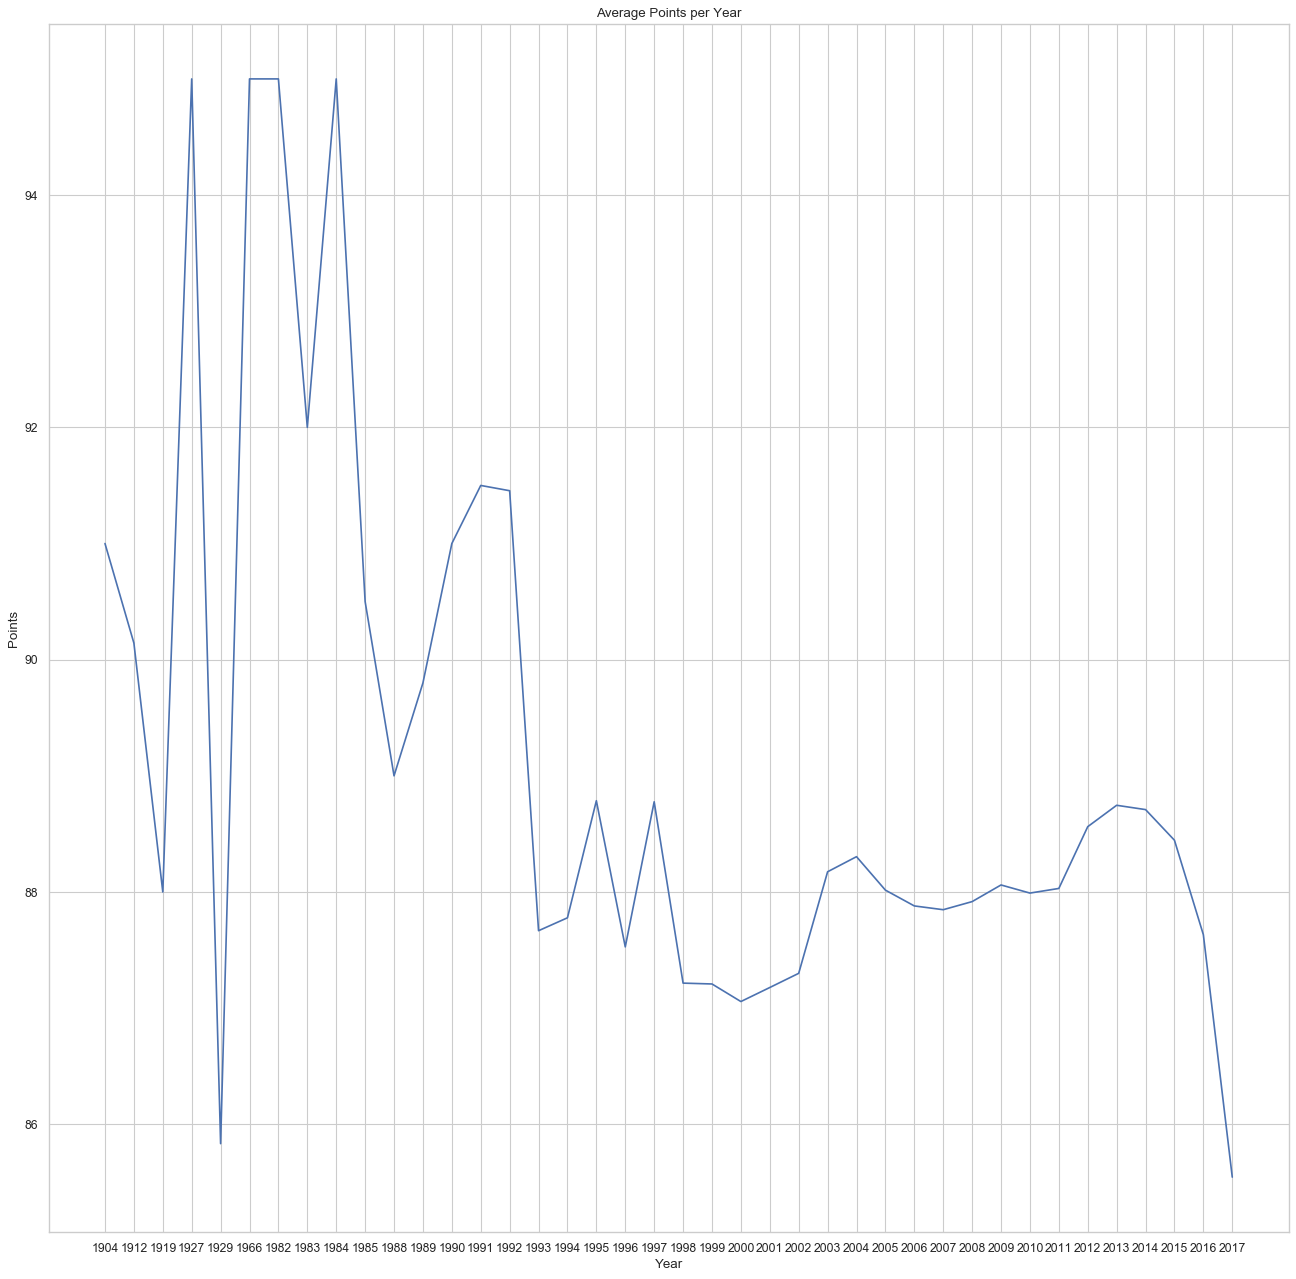

In [23]:
# Plot points vs price data
# Grouping by points
yearGroup = wine_data.groupby('year').mean()
plt.figure(figsize=(20, 20), dpi=80)
plt.plot(yearGroup['points'], c='b' )
plt.title("Average Points per Year")
plt.xlabel("Year")
plt.ylabel("Points")

In [24]:
column_values = wine_data[["variety"]].values.ravel()
unique_values =  pd.unique(column_values)
print(len(unique_values))

687


Text(0, 0.5, 'Points')

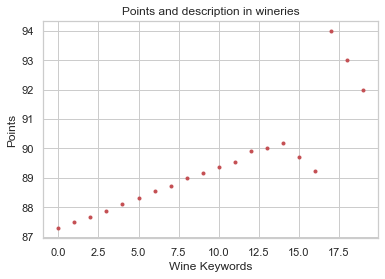

In [25]:
# Plot points vs description data
descriptionGroup = wine_data.groupby('wine_keywords').mean()
plt.plot(descriptionGroup['points'], "r.")
plt.title("Points and description in wineries")
plt.xlabel("Wine Keywords")
plt.ylabel("Points")

Text(0, 0.5, 'Points')

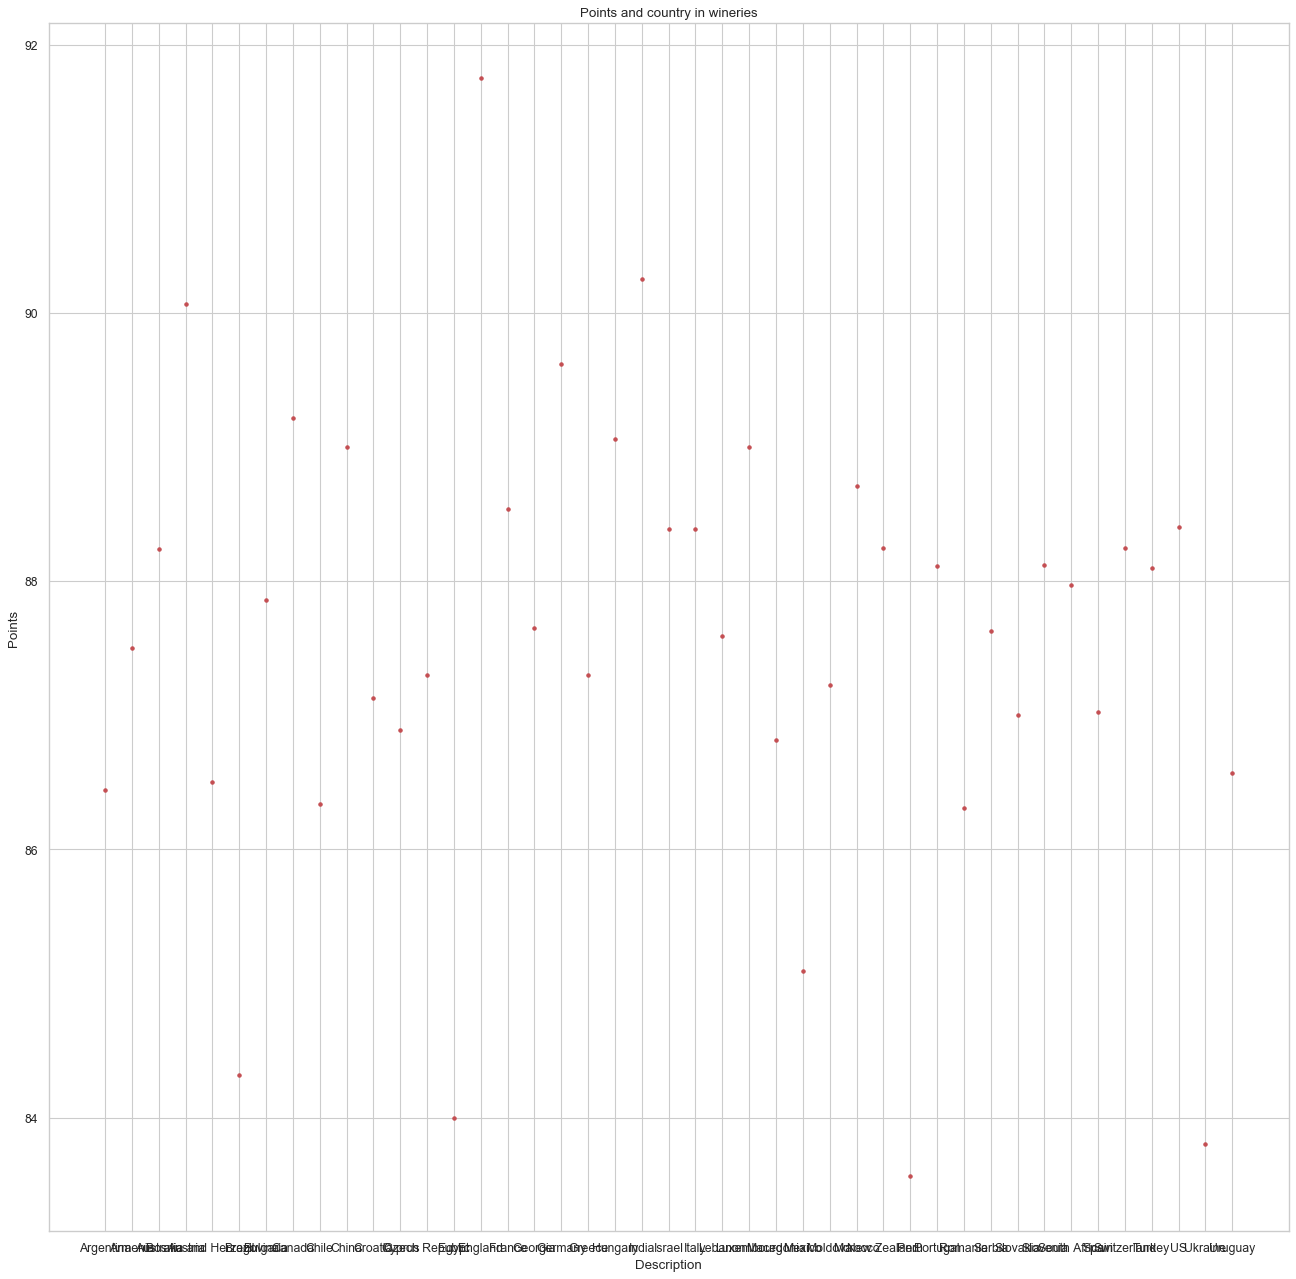

In [26]:
# Plot points vs country data
countryGroup = wine_data.groupby('country').mean()
plt.figure(figsize=(20, 20), dpi=80)
plt.plot(countryGroup['points'], "r.")
plt.title("Points and country in wineries")
plt.xlabel("Description")
plt.ylabel("Points")

Text(0, 0.5, 'Points')

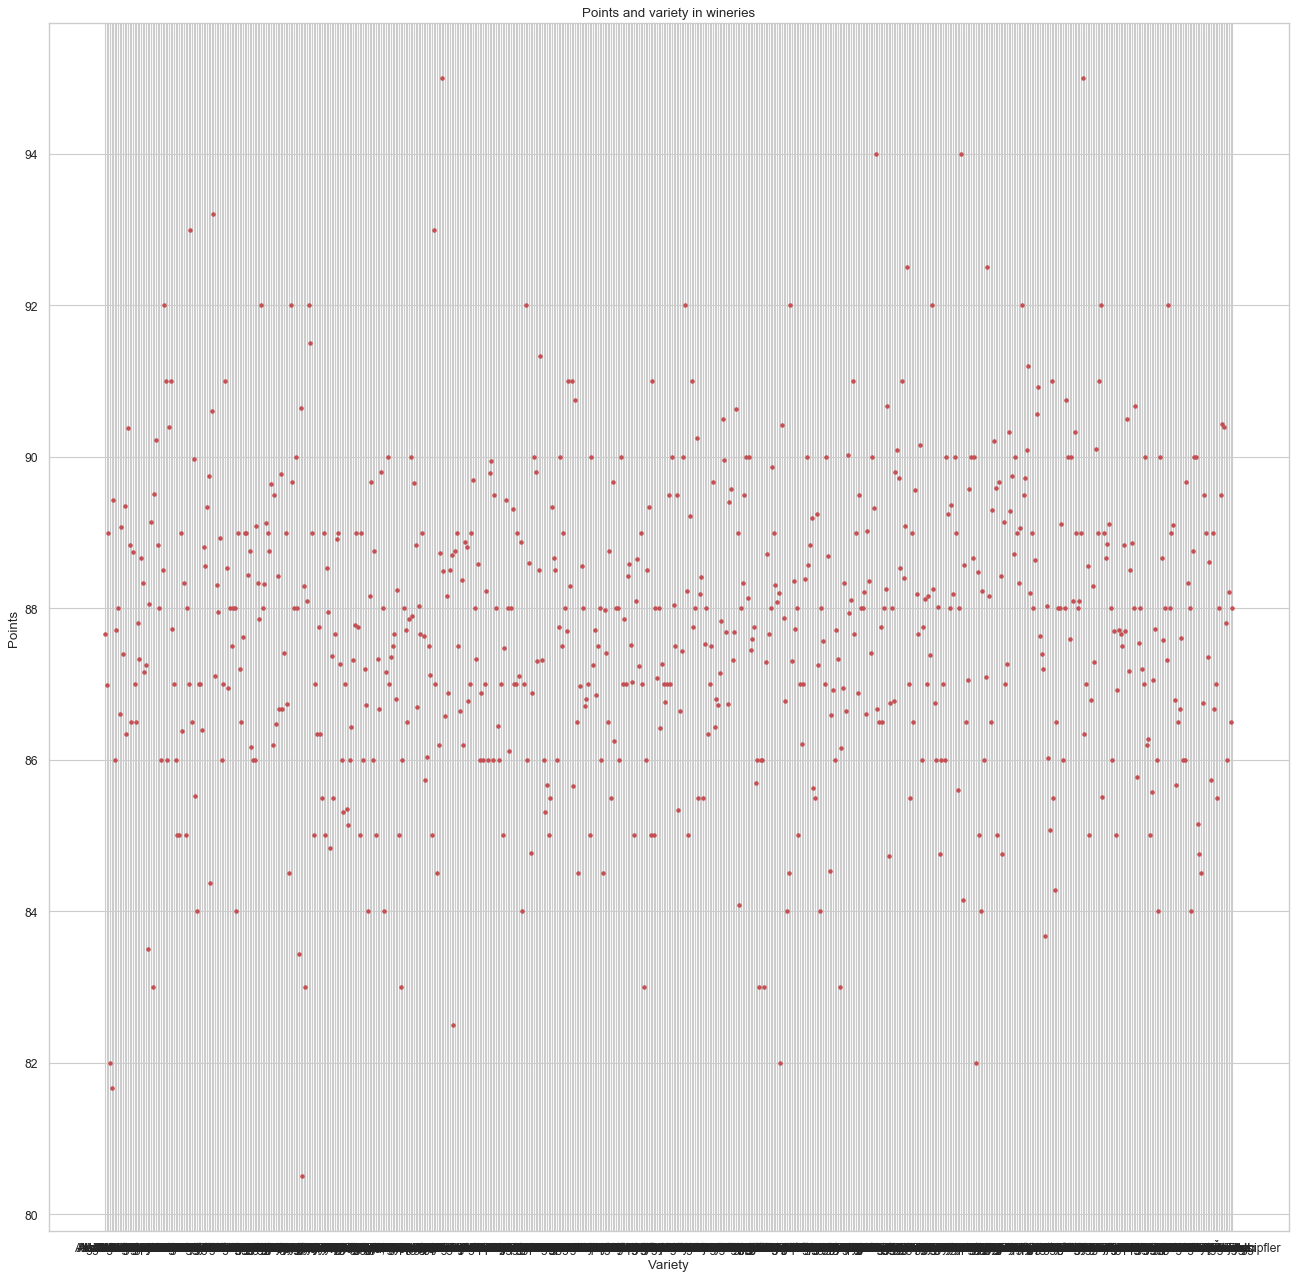

In [27]:
# Plot points vs variety data
varietyGroup = wine_data.groupby('variety').mean()
plt.figure(figsize=(20, 20), dpi=80)
plt.plot(varietyGroup['points'], "r.")
plt.title("Points and variety in wineries")
plt.xlabel("Variety")
plt.ylabel("Points")

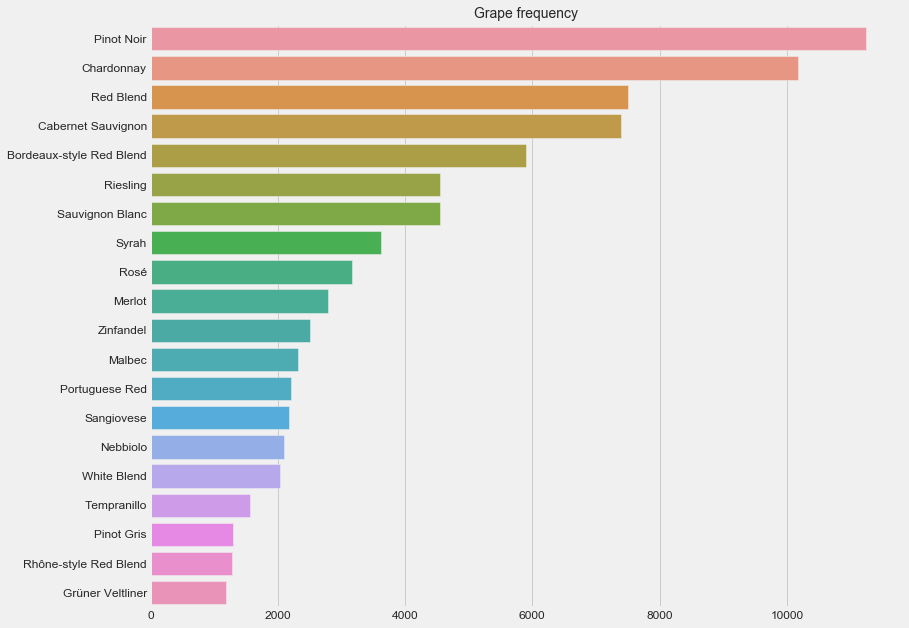

In [28]:
# Get label frequencies in descending order
label_freq = wine_data['variety'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.iloc[:20].index)
plt.title("Grape frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
rare = list(label_freq[label_freq<700].index)
# Transform the rare ones to just "Other"
wine_data['variety'] = wine_data['variety'].apply(lambda s: str(s) if s not in rare else 'Other')

Text(0, 0.5, 'Points')

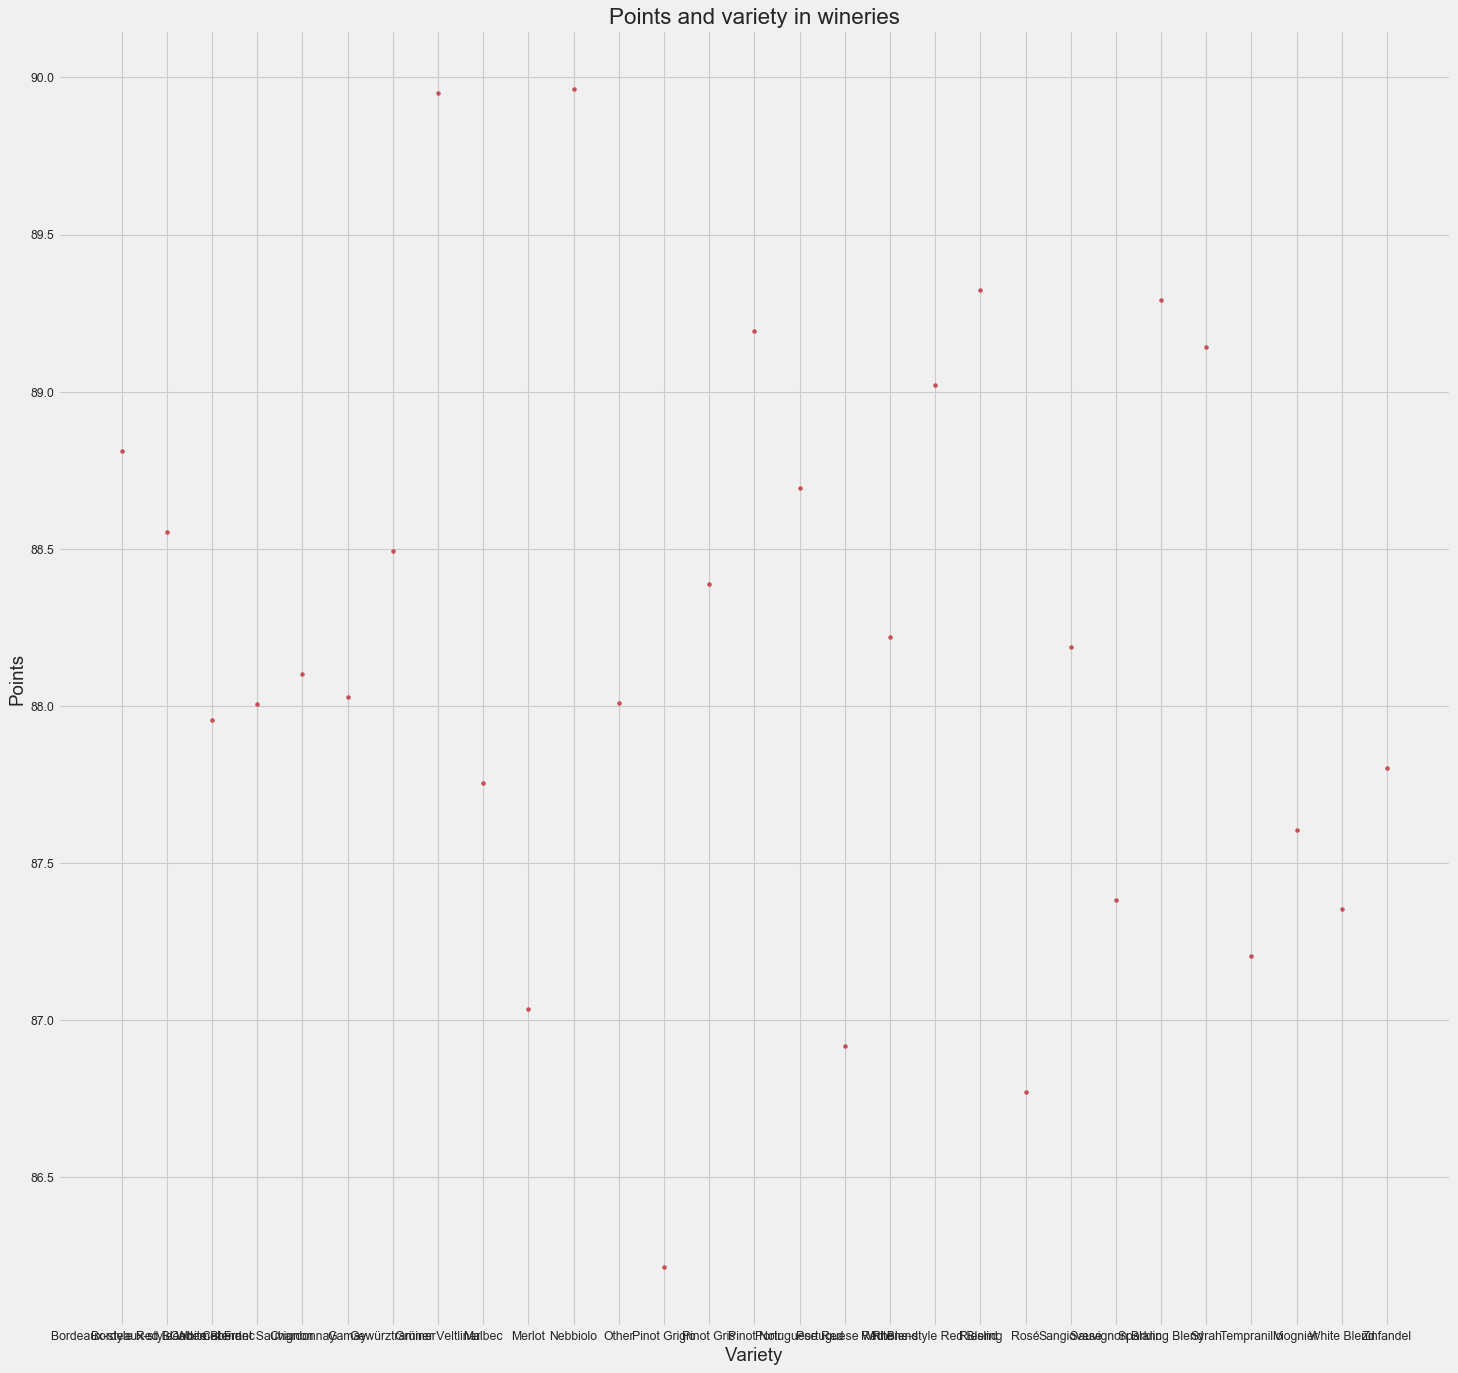

In [30]:
# Plot points vs reduced variety grouped data
varietyGroup = wine_data.groupby('variety').mean()
plt.figure(figsize=(20, 20), dpi=80)
plt.plot(varietyGroup['points'], "r.")
plt.title("Points and variety in wineries")
plt.xlabel("Variety")
plt.ylabel("Points")

In [31]:
# One Hot Encoding for Categorical Data
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([wine_data,pd.get_dummies(wine_data['country'], prefix='country')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df.drop(['country'],axis=1, inplace=True)

In [32]:
df.head(20)

,points,price,variety,year,wine_keywords,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,...,country_Serbia,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,country_Switzerland,country_Turkey,country_US,country_Ukraine,country_Uruguay
0,87,29.123639,White Blend,2013,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87,15.000000,Portuguese Red,2011,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87,14.000000,Pinot Gris,2013,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,87,13.000000,Riesling,2013,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,87,65.000000,Pinot Noir,2012,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,87,15.000000,Other,2011,10,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,87,16.000000,Other,2013,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,87,24.000000,Gewürztraminer,2012,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,87,12.000000,Gewürztraminer,2013,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,87,27.000000,Pinot Gris,2012,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df = pd.concat([df,pd.get_dummies(df['variety'], prefix='variety')],axis=1)

# now drop the original 'variety' column (you don't need it anymore)
df.drop(['variety'],axis=1, inplace=True)
df.head(20)

,points,price,year,wine_keywords,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,...,variety_Riesling,variety_Rosé,variety_Sangiovese,variety_Sauvignon Blanc,variety_Sparkling Blend,variety_Syrah,variety_Tempranillo,variety_Viognier,variety_White Blend,variety_Zinfandel
0,87,29.123639,2013,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,87,15.000000,2011,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87,14.000000,2013,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87,13.000000,2013,6,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,87,65.000000,2012,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,87,15.000000,2011,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87,16.000000,2013,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,87,24.000000,2012,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,87,12.000000,2013,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,87,27.000000,2012,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Normalize only numerical data
# Standardize data object
scaler = StandardScaler()
scaler.fit(df[['price', 'year', 'wine_keywords']])
# Apply transform to data set
df[['price', 'year', 'wine_keywords']] = scaler.transform(df[['price', 'year', 'wine_keywords']])


In [35]:
df.head(10)

,points,price,year,wine_keywords,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,...,variety_Riesling,variety_Rosé,variety_Sangiovese,variety_Sauvignon Blanc,variety_Sparkling Blend,variety_Syrah,variety_Tempranillo,variety_Viognier,variety_White Blend,variety_Zinfandel
0,87,-0.005427,0.625494,-0.734978,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,87,-0.909830,0.094287,-1.170451,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87,-0.973865,0.625494,0.135968,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87,-1.037899,0.625494,0.571441,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,87,2.291904,0.359890,-0.299505,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,87,-0.909830,0.094287,2.313332,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,87,-0.845795,0.625494,-0.299505,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,87,-0.333518,0.359890,-0.734978,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,87,-1.101934,0.625494,-0.734978,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,87,-0.141414,0.359890,1.006914,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Bootstrap original data to train and test data set.
# Keep this test data set for last
first_train = df.sample(frac = 0.7, replace = True, random_state=123)
first_test = df.sample(frac = 0.3, replace = True, random_state=123)
first_train.to_csv('/Users/ajz/Desktop/DS3001/Project/TrainDataNormalized.csv')
first_test.to_csv('/Users/ajz/Desktop/DS3001/Project/finalTestDataNormalized.csv')